Import Necessary Libraries

In [1]:
import os
import pandas as pd
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import re 

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.cluster import DBSCAN
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    silhouette_score,
    accuracy_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    confusion_matrix
)
import json
from pandas import json_normalize
from datetime import datetime
from matplotlib.patches import Circle

In [2]:
df = pd.read_csv('flattened_telemetry.csv', sep=',', low_memory=False)
df

,_id,ulCarrierFreq,timestamp,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,...,ulMcs,rssi,cqi,pucchSnr,puschSnr,rnti,dlBytes,phr,pmi_0,pmi_1
0,67c20d2e037f557dd6e2cd3f,3.750240e+09,2025-02-28 19:23:26.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,67c20d2f037f557dd6e2cd40,3.750240e+09,2025-02-28 19:23:27.263000064,12345678.0,0.0,0.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,67c20d30037f557dd6e2cd41,3.750240e+09,2025-02-28 19:23:28.263000064,12345678.0,213.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,67c20d31037f557dd6e2cd42,3.750240e+09,2025-02-28 19:23:29.263000064,12345678.0,313.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,67c20d32037f557dd6e2cd43,3.750240e+09,2025-02-28 19:23:30.263000064,12345678.0,413.0,4.0,0.0,3.750240e+09,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176428,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,21.5,f0e1,10641.0,61.0,15.0,1.0
176429,6811e64dc12140b28bc1344c,3.750240e+09,2025-04-30 08:58:53.132000000,12345678.0,350.0,4.0,0.0,3.750240e+09,69.0,6.0,...,6.0,96.0,15.0,15.0,31.0,93aa,24353.0,59.0,0.0,1.0
176430,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,62.0,6.0,...,6.0,62.0,15.0,5.0,3.0,b078,19416.0,52.0,2.0,1.0
176431,6811e64ec12140b28bc1344d,3.750240e+09,2025-04-30 08:58:54.132000000,12345678.0,444.0,3.0,0.0,3.750240e+09,0.0,6.0,...,6.0,90.7,15.0,20.0,27.0,f0e1,10786.0,61.0,15.0,1.0


Training DATA Analysis

In [3]:
df.shape # size of the training data (#rows, #features)

(176433, 29)

In [4]:
df.dropna(inplace = True) # dropping NaN Values i.e removing all empty noisy data
df.shape # size after removing NaN values

(168861, 29)

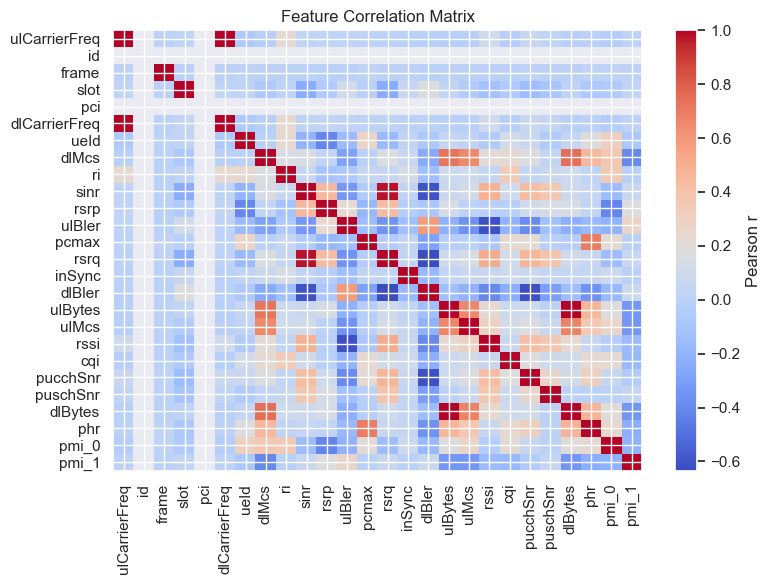

In [5]:
#Analysing the correlation between features (Only Numeric features)
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
corr = df[numeric_cols] .corr()
scaler = StandardScaler()
df1 = pd.DataFrame()
df1[numeric_cols] = scaler.fit_transform(df[numeric_cols])

#print("Correlation matrix:\n", corr)

# Visualize with a heatmap
plt.figure(figsize=(8, 6))
plt.imshow(corr, cmap='coolwarm', interpolation='nearest', aspect='auto')
plt.colorbar(label='Pearson r')
plt.xticks(range(len(corr)), corr.columns, rotation=90)
plt.yticks(range(len(corr)), corr.columns)
plt.title('Feature Correlation Matrix')
plt.tight_layout()
plt.show()

Removing 2% of outliers/Noisy data using Isolation Forest

In [6]:
from sklearn.ensemble import IsolationForest

numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df['iforest_label'] = iso.fit_predict(df[numeric_cols])
# label = −1 is an outlier
n_iso = (df['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df):.2%})")

IsolationForest outliers: 1689 (1.00%)


In [7]:
df = df[df['iforest_label'] == 1].reset_index(drop=True) #keeping only inliners
df.drop(columns=['iforest_label'], inplace=True)

In [8]:
df.describe()

,ulCarrierFreq,id,frame,slot,pci,dlCarrierFreq,ueId,dlMcs,ri,sinr,...,ulBytes,ulMcs,rssi,cqi,pucchSnr,puschSnr,dlBytes,phr,pmi_0,pmi_1
count,1.671720e+05,167172.0,167172.000000,167172.000000,167172.0,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,...,1.671720e+05,167172.000000,167172.000000,167172.000000,167172.000000,167172.000000,1.671720e+05,167172.000000,167172.000000,167172.000000
mean,3.750306e+09,12345678.0,509.845471,10.709515,0.0,3.750306e+09,22.580516,10.139832,1.932644,21.165294,...,1.467366e+09,7.372090,77.384429,14.520045,14.363141,15.321190,6.683665e+08,53.555775,8.591182,0.597768
std,1.404990e+06,0.0,295.017824,6.528031,0.0,1.404990e+06,10.364159,7.632047,0.268342,7.940488,...,4.395379e+09,2.707526,6.998459,1.805117,5.032339,7.566763,1.814033e+09,7.887585,5.979025,0.545379
min,3.750240e+09,12345678.0,0.000000,2.000000,0.0,3.750240e+09,1.000000,0.000000,1.000000,-10.000000,...,0.000000e+00,0.000000,59.800000,1.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,3.750240e+09,12345678.0,254.000000,4.000000,0.0,3.750240e+09,20.000000,6.000000,2.000000,23.500000,...,1.259912e+06,6.000000,75.000000,15.000000,13.000000,12.000000,4.649668e+05,52.000000,0.000000,0.000000
50%,3.750240e+09,12345678.0,507.000000,9.000000,0.0,3.750240e+09,22.000000,9.000000,2.000000,23.500000,...,8.041060e+06,6.000000,79.900000,15.000000,15.000000,16.000000,2.219774e+06,52.000000,11.000000,1.000000
75%,3.750240e+09,12345678.0,766.000000,19.000000,0.0,3.750240e+09,24.000000,9.000000,2.000000,23.500000,...,3.637968e+07,8.000000,81.500000,15.000000,16.000000,18.000000,1.211683e+08,52.000000,13.000000,1.000000
max,3.780300e+09,12345678.0,1023.000000,19.000000,0.0,3.780300e+09,69.000000,27.000000,4.000000,23.500000,...,2.275132e+10,27.000000,120.000000,15.000000,60.000000,63.500000,9.106684e+09,65.000000,15.000000,3.000000


In [9]:
#features in the data
df.columns

Index(['_id', 'ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', 'ueId', 'dlMcs', 'ri', 'sinr', 'rsrp', 'ulBler',
       'pcmax', 'rsrq', 'inSync', 'dlBler', 'ulBytes', 'ulMcs', 'rssi', 'cqi',
       'pucchSnr', 'puschSnr', 'rnti', 'dlBytes', 'phr', 'pmi_0', 'pmi_1'],
      dtype='object')

Considering the following features for user signature:
'rnti'
'rsrp'
'pucchSnr'
'rssi'
'ulBler'
'puschSnr'
'dlBler'
'rsrq'
'sinr'


In [10]:
to_drop = [
    '_id', 'id', 'ueId',  'cqi',    # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df = df.drop(columns=to_drop, errors='ignore')

df.columns

Index(['sinr', 'rsrp', 'ulBler', 'rsrq', 'dlBler', 'rssi', 'pucchSnr',
       'puschSnr', 'rnti'],
      dtype='object')

In [11]:
df.head()

,sinr,rsrp,ulBler,rsrq,dlBler,rssi,pucchSnr,puschSnr,rnti
0,12.0,-89.0,0.169858,-11.0,0.065610,100.3,40.0,34.0,b39a
1,11.5,-89.0,0.275585,-11.0,0.059049,86.0,38.0,21.5,b39a
2,11.5,-89.0,0.444611,-11.0,0.047830,83.7,39.0,16.5,b39a
3,11.5,-89.0,0.397827,-11.0,0.038742,82.4,35.0,15.0,b39a
4,11.5,-89.0,0.396927,-11.0,0.031381,82.6,32.0,15.0,b39a


In [12]:
raw_cols = ['sinr','rsrp','rssi','pucchSnr','puschSnr','ulBler','dlBler','rsrq']
scaler_raw = StandardScaler() # Normalise
df_scaled = pd.DataFrame() # A new DataFrame to work on
df_scaled[raw_cols] = scaler_raw.fit_transform(df[raw_cols])


In [13]:
df_scaled['rnti']= df['rnti'] 

In [14]:
df_scaled.head()

,sinr,rsrp,rssi,pucchSnr,puschSnr,ulBler,dlBler,rsrq,rnti
0,-1.154252,-1.362237,3.274384,5.094437,2.468541,-0.466089,-0.236657,0.0823,b39a
1,-1.217220,-1.362237,1.231071,4.697006,0.816575,-0.221125,-0.256792,0.0823,b39a
2,-1.217220,-1.362237,0.902426,4.895722,0.155788,0.170499,-0.291221,0.0823,b39a
3,-1.217220,-1.362237,0.716670,4.100860,-0.042448,0.062103,-0.319111,0.0823,b39a
4,-1.217220,-1.362237,0.745248,3.504714,-0.042448,0.060018,-0.341701,0.0823,b39a


CREATING TIME WINDOWED SEQUENCES for each window: the mean of the features and their corresponding correalations are captured

In [15]:

def extract_phy_signatures(df_scaled,
                           raw_features=None,
                           window_size=50,
                           step_size=50,
                           label_col=None):
    """
    Slide a window over df and for each window compute:
      - mean of each raw_feature
      - Pearson correlation of every pair of raw_features

    Parameters
    ----------
    df : pd.DataFrame
        Preprocessed, timestamp-sorted DataFrame of physical-layer columns.
    raw_features : list of str, optional
        Columns to treat as the base attributes. If None, defaults to:
        ['sinr','rsrp','rssi','cqi','pucchSnr','puschSnr','ulBler','dlBler']
    window_size : int
        Number of rows per window.
    step_size : int
        Sliding step between windows (use ==window_size for non-overlap).
    label_col : str, optional
        Name of a column (e.g. 'rnti' or 'ueId') whose mode in each window
        will be returned as the true label for that signature.

    Returns
    -------
    sig_df : pd.DataFrame
        Each row is a signature: [mean_{f1} … mean_{fD}, corr_{f1,f2} …]
    labels : list, only if label_col is set
        The mode of `label_col` in each window, in the same order as sig_df.
    """
    if raw_features is None:
        raw_features = [
            'sinr', 'rsrp', 'rssi','rsrq',
            'pucchSnr', 'puschSnr', 'ulBler', 'dlBler'
        ]

    D = len(raw_features)
    # build column names
    #corr_pairs = [(i, j) for i in range(D) for j in range(i+1, D)]
    col_names = ([f"mean_{f}" for f in raw_features])# +
                #[f"corr_{raw_features[i]}_{raw_features[j]}" 
                #   for i,j in corr_pairs])

    signatures = []
    labels = []  # only used if label_col is provided

    for start in range(0, len(df_scaled) - window_size + 1, step_size):
        w = df_scaled.iloc[start:start+window_size]

        # 1) raw means
        means = w[raw_features].mean().values

        # 2) correlations
        #cmat = w[raw_features].corr().values
        #iu = np.triu_indices(D, k=1)
        #corr_vals = cmat[iu]

        #signatures.append(np.concatenate([means, corr_vals]))
        signatures.append(means)
        # 3) window label (mode of label_col)
        if label_col is not None:
            labels.append(w[label_col].mode()[0])

    sig_df = pd.DataFrame(signatures, columns=col_names)
    if label_col is not None:
        return sig_df, labels
    return sig_df


# ----------------------------
# Example usage:



# 2) Get signatures *and* the per-window RNTI mode



In [16]:
sig_df, window_rntis = extract_phy_signatures(
    df_scaled,
    window_size=100,
    step_size=100,
    label_col='rnti'
)

In [17]:
sig_df.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler'],
      dtype='object')

In [18]:
sig_df.describe()

,mean_sinr,mean_rsrp,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler
count,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000,1671.000000
mean,0.000514,0.001142,0.000225,0.000085,0.000418,0.000128,-0.000546,-0.000720
std,0.732608,0.621450,0.564616,0.701383,0.501820,0.368854,0.627489,0.780060
min,-2.787658,-2.027642,-2.066380,-2.520190,-2.053354,-1.651463,-0.859641,-0.438005
25%,0.285840,-0.130004,-0.088867,0.252242,-0.063219,-0.101918,-0.289806,-0.435624
50%,0.294026,-0.061547,0.107391,0.279907,0.114631,0.044115,-0.137364,-0.410621
75%,0.294026,0.229397,0.238206,0.279907,0.258699,0.187506,0.279310,-0.150359
max,0.294026,3.019035,3.895665,0.279907,2.455497,1.735068,1.457306,2.571764


In [19]:
sig_df['rnti_true'] = window_rntis

In [20]:
n_total = len(sig_df)

# number of windows with any NaN
n_with_nan = sig_df.isna().any(axis=1).sum()

print(f"{n_with_nan} out of {n_total} windows ({n_with_nan/n_total:.1%}) have at least one NaN")

0 out of 1671 windows (0.0%) have at least one NaN


In [21]:
nan_per_col = sig_df.isna().sum().sort_values(ascending=False)
print(nan_per_col)

mean_sinr        0
mean_rsrp        0
mean_rssi        0
mean_rsrq        0
mean_pucchSnr    0
mean_puschSnr    0
mean_ulBler      0
mean_dlBler      0
rnti_true        0
dtype: int64


In [22]:
sig_df = sig_df.fillna(0)
sig_df

,mean_sinr,mean_rsrp,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler,rnti_true
0,-1.175661,-1.362237,1.108900,0.082300,0.621355,-0.135619,-0.757874,-0.426701,b39a
1,-1.168105,-1.362237,1.089610,0.082300,0.923402,0.069225,-0.615395,-0.408462,c601
2,-1.175661,-1.362237,1.070606,0.082300,0.321295,0.133982,-0.817764,-0.438005,c601
3,-1.177550,-1.362237,1.096469,0.082300,0.053029,0.060635,-0.841132,-0.438005,c601
4,-1.174402,-1.362237,1.098327,0.082300,0.037132,0.067243,-0.859641,-0.438005,c601
...,...,...,...,...,...,...,...,...,...
1666,0.002482,-1.471768,0.950151,0.200864,1.765955,0.733316,0.818647,1.361307,2e6c
1667,-0.503786,-1.538857,0.380881,0.064515,2.123643,0.349399,1.261352,1.724905,2e6c
1668,-0.693951,-1.651127,0.658657,0.028946,2.147489,0.686400,1.387654,2.021417,98f2
1669,-0.726065,-1.740121,-0.723937,0.017089,1.980568,-0.351035,1.291371,2.064360,719e


In [23]:
#nan_frac = sig_df.isna().mean()

# 2. Choose a threshold (e.g. 0.5 for 50%)
#threshold = 0.5

# 3. Identify columns to drop vs keep
#drop_cols = nan_frac[nan_frac > threshold].index.tolist()
#keep_cols = nan_frac[n0.an_frac <= threshold].index.tolist()

#print(f"Dropping {len(drop_cols)} columns with >{threshold*100:.0f}% NaNs:")
#print(drop_cols)
#print(f"\nKeeping {len(keep_cols)} columns with ≤{threshold*100:.0f}% NaNs:")
#print(keep_cols)

In [24]:
#sig_df.drop(columns= drop_cols, inplace = True)

In [25]:
#sig_df.dropna(inplace = True)

In [26]:
sig_df.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler', 'rnti_true'],
      dtype='object')

APPLY K-Means CLustering on whole data to determine the number of clusters

In [27]:
X = sig_df.drop(columns = 'rnti_true').values
best_k, best_score = 2, -1
for k in range(2, 30):
    km = KMeans(n_clusters=k, random_state=0, init='k-means++').fit(X)
    score = silhouette_score(X, km.labels_)
    print(score)
    if score > best_score:
        best_k, best_score = k, score

print(f"Optimal K ≈ {best_k} (silhouette={best_score:.3f})")

# 2. Fit final k-means
km_final = KMeans(n_clusters=best_k, random_state=0, init='k-means++').fit(X)
labels   = km_final.labels_
centroids= km_final.cluster_centers_

# 3. Attach back to your sig_df
sig_df['kmeans_label'] = labels

0.6847657197028371
0.7298725817407722
0.4038556170246281
0.41724908697884916
0.42388192450047485
0.4191844876444851
0.4486020820075407
0.435873979750328
0.4341951327438367
0.44809371446387297
0.2864901723570279
0.3110751954220327
0.32847612331466
0.32590549268030516
0.3352934440508775
0.36178463448342807
0.48465666594058365
0.4840249300708694
0.489276984742843
0.3772894164402724
0.3811016237896024
0.3779756555348198
0.3781690315799919
0.3781081817146144
0.37828059887654875
0.37947963058127715
0.3864689952363421
0.3865869203387515
Optimal K ≈ 3 (silhouette=0.730)


PCA PROJECTION TO VISUALISE THE CLUSTERS ON 2 PRINCIPLE COMPONENTS

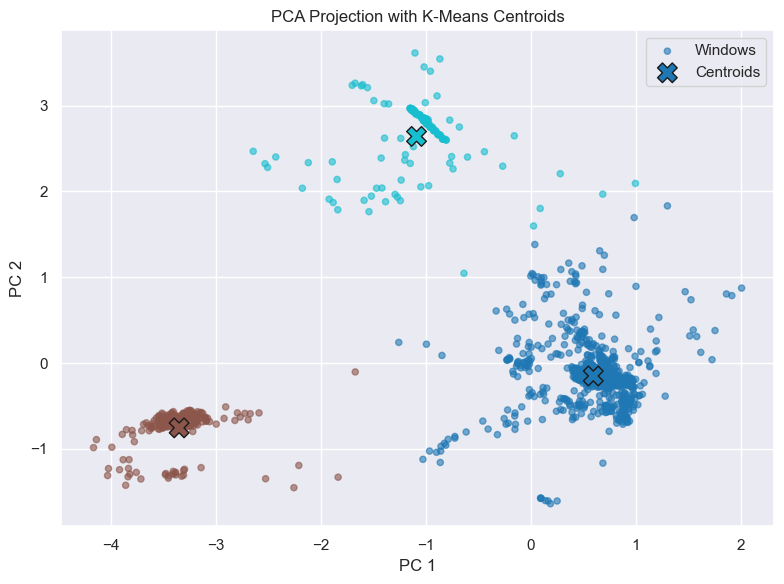

In [28]:
labels = sig_df['kmeans_label'].values        # or 'dbscan_label'

pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)

# 2. Project centroids into the same PCA space
centroids = km_final.cluster_centers_               # shape (K, n_features)
centroids_pca = pca.transform(centroids)      # shape (K, 2)

# 3. Scatter plot of windows
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_pca[:,0], X_pca[:,1],
    c=labels,
    cmap='tab10',
    s=20,
    alpha=0.6,
    label="Windows"
)

# 4. Overlay centroids
plt.scatter(
    centroids_pca[:,0], centroids_pca[:,1],
    c=range(len(centroids_pca)),
    cmap='tab10',
    marker='X',
    s=200,
    edgecolor='k',
    label="Centroids"
)

plt.legend(loc='best')
plt.xlabel("PC 1")
plt.ylabel("PC 2")
plt.title("PCA Projection with K-Means Centroids")
plt.tight_layout()
plt.show()


TSNE : NON LINEAR PROJECTION ON 2 COMPOENTNS

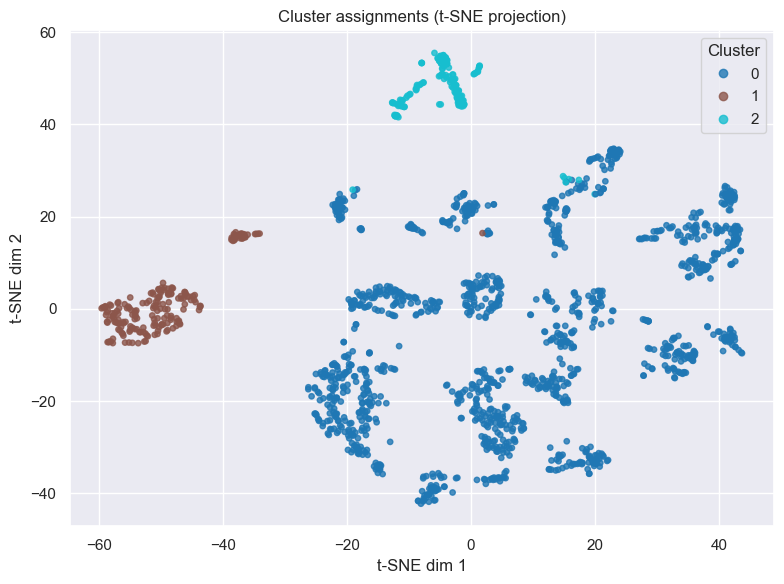

In [29]:
from sklearn.manifold import TSNE

# 1. Embed in 2D with t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
X_tsne = tsne.fit_transform(X)

# 2. Plot
plt.figure(figsize=(8,6))
scatter = plt.scatter(
    X_tsne[:,0], X_tsne[:,1],
    c=labels,
    cmap='tab10',
    s=15,
    alpha=0.8
)
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.xlabel("t-SNE dim 1")
plt.ylabel("t-SNE dim 2")
plt.title("Cluster assignments (t-SNE projection)")
plt.tight_layout()
plt.show()

TESTING ON NEW DATA(AUTHENTIC AND NON-AUTHENTIC): READ the DATA FILES THAT You want to test on

In [30]:
#preprocessing test data

In [31]:
#authentic_1_noise_less_antennas.csv
#authentic_2_normal.csv
#authentic_3_obstacles.csv
#non_authentic_1_diff_position.csv
#non_authentic_2_less_antennas_diff_position.csv
#non_authentic_3_no_antennas.csv

In [32]:
df1 = pd.read_csv('non_authentic_3_no_antennas.csv', sep=',', low_memory=False) # read the testing data files

In [33]:
df1.columns

Index(['ulCarrierFreq', 'timestamp', 'id', 'frame', 'slot', 'pci',
       'dlCarrierFreq', '_id.$oid', 'avgLdpcIterations', 'rnti', 'ulBytes',
       'pmi', 'rsrp', 'cqi', 'pucchSnr', 'rssi', 'ueId', 'inSync', 'dlBytes',
       'dlMcs', 'ulMcs', 'ulBler', 'ri', 'pcmax', 'puschSnr', 'dlBler', 'phr',
       'rsrq', 'sinr'],
      dtype='object')

In [34]:
#drop the Nan values and remove outliers using Isolation Forest

In [35]:
df1.dropna(inplace = True)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
iso = IsolationForest(contamination=0.01, random_state=42)
df1['iforest_label'] = iso.fit_predict(df1[numeric_cols])
# label = −1 is an outlier
n_iso = (df1['iforest_label'] == -1).sum()
print("IsolationForest outliers:", n_iso, f"({n_iso/len(df1):.2%})")
df1 = df1[df1['iforest_label'] == 1].reset_index(drop=True)
df1.drop(columns=['iforest_label'], inplace=True)

IsolationForest outliers: 167 (1.00%)


In [36]:
#Keep the features same as training data

to_drop = [
    '_id', 'id', 'ueId',  'cqi', '_id.$oid', 'avgLdpcIterations', 'pmi',  # network IDs
    'timestamp', 'frame', 'slot',       # timing/order markers
    'pci', 'ulCarrierFreq', 'dlCarrierFreq',  # cell/carrier config
    'dlMcs', 'ulMcs', 'ri', 'pmi_0', 'pmi_1', 'phr', 'pcmax',  # control/scheduling
    'ulBytes', 'dlBytes', 'inSync'     # traffic & state
]

df1 = df1.drop(columns=to_drop, errors='ignore')

print(df1.columns)
numeric_cols = df1.select_dtypes(include=[np.number]).columns.tolist()
scaler = StandardScaler() # Normalise using StandardSCALER
df1[numeric_cols] = scaler.fit_transform(df1[numeric_cols])
print(df1.head())

Index(['rnti', 'rsrp', 'pucchSnr', 'rssi', 'ulBler', 'puschSnr', 'dlBler',
       'rsrq', 'sinr'],
      dtype='object')
   rnti      rsrp  pucchSnr      rssi    ulBler  puschSnr    dlBler      rsrq  \
0  30be  1.382723  0.376472  0.205716 -1.043344  0.356751  0.048947  0.563005   
1  23b3  0.730811  0.139544 -0.076750  1.087956  0.231272 -0.444511  0.563005   
2  308f -1.343455  1.798043 -2.936717  1.087956 -1.588159  2.597808 -1.924997   
3  6695 -0.158160  0.376472  0.505836  0.983630  0.105794  0.007137  0.563005   
4  7acd -1.402719 -2.703598 -2.936717  1.087956 -1.839115  2.597808 -2.256730   

       sinr  
0  0.646472  
1  0.558259  
2 -1.558851  
3  0.073088  
4 -1.647064  


In [37]:
#prepare the time windowed sequences for test data

In [38]:
sig_df_test, window_rntis_test = extract_phy_signatures(
    df1,
    window_size=100,
    step_size=100,
    label_col='rnti'
)


In [39]:

sig_df_test.columns

Index(['mean_sinr', 'mean_rsrp', 'mean_rssi', 'mean_rsrq', 'mean_pucchSnr',
       'mean_puschSnr', 'mean_ulBler', 'mean_dlBler'],
      dtype='object')

In [40]:
#Evaluate the performance

In [41]:
from sklearn.metrics import pairwise_distances

X = sig_df.drop(columns=['rnti_true','kmeans_label'], errors='ignore').values
X_new = sig_df_test.drop(columns='rnti_true', errors='ignore').values

# Train labels and assigned cluster distances
train_labels = km_final.labels_
train_dists = pairwise_distances(X, km_final.cluster_centers_)
train_assigned_dists = np.array([
    train_dists[i, label] for i, label in enumerate(train_labels)
])

# Per-cluster threshold
cluster_thresholds = {}
for k in range(km_final.n_clusters):
    dists_k = train_assigned_dists[train_labels == k]
    cluster_thresholds[k] = np.percentile(dists_k, 95)

# Predict on new data
new_labels = km_final.predict(X_new)
test_dists = pairwise_distances(X_new, km_final.cluster_centers_)

# Distances to assigned centroid
sig_df_test['new_dists'] = np.array([
    test_dists[i, new_labels[i]] for i in range(len(new_labels))
])

# Label based on distance to assigned cluster centroid
sig_df_test['authenticity'] = [
    'authentic' if sig_df_test['new_dists'][i] <= cluster_thresholds[new_labels[i]] else 'non_authentic'
    for i in range(len(new_labels))
]

In [42]:
cluster_thresholds

{0: 1.8176143270522547, 1: 1.3037106293804288, 2: 2.690012011971408}

In [43]:
sig_df_test

,mean_sinr,mean_rsrp,mean_rssi,mean_rsrq,mean_pucchSnr,mean_puschSnr,mean_ulBler,mean_dlBler,new_dists,authenticity
0,-0.429285,-0.178310,-0.994411,-0.498542,-0.403023,-0.416822,0.636989,0.871147,2.197381,non_authentic
1,-0.451338,-0.174162,-1.070147,-0.500201,-0.457516,-0.423095,0.638611,0.828966,2.177054,non_authentic
2,-0.459718,-0.175347,-1.113929,-0.515129,-0.350898,-0.404901,0.642926,0.880953,2.175732,non_authentic
3,-0.498973,-0.178903,-1.019303,-0.566548,-0.578350,-0.471404,0.620870,0.841843,2.082255,non_authentic
4,-0.495885,-0.180088,-1.024423,-0.546644,-0.727615,-0.410548,0.596604,0.811211,2.097901,non_authentic
...,...,...,...,...,...,...,...,...,...,...
160,0.175856,0.106753,0.367605,0.189805,0.499675,0.344830,-0.348399,-0.397115,0.497964,authentic
161,0.183795,0.108531,0.445283,0.198098,0.513891,0.109559,-0.338930,-0.441573,0.482946,authentic
162,0.178502,0.108531,0.342006,0.208050,0.530476,0.259505,-0.355412,-0.476202,0.483354,authentic
163,0.160419,0.107939,0.444577,0.201416,0.497306,0.028625,-0.347592,-0.431488,0.478598,authentic


In [44]:
print(sig_df_test['authenticity'].value_counts())

authenticity
authentic        132
non_authentic     33
Name: count, dtype: int64


In [45]:
explained_var = pca.explained_variance_ratio_
total_var = explained_var.sum()
print(total_var)

0.8128222570135254


In [46]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X)  # X from your training data
centroids_pca = pca.transform(km_final.cluster_centers_)

In [47]:
X_new_pca = pca.transform(X_new)

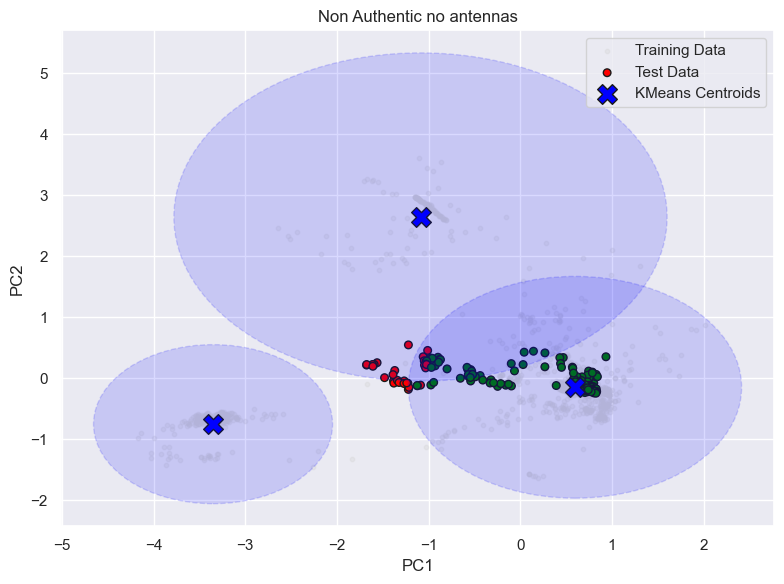

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))

# Plot training data (light gray background)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c='lightgray', s=10, alpha=0.3, label='Training Data')

# Plot new test data points
color_map = {'authentic': 'green', 'non_authentic': 'red'}
colors = sig_df_test['authenticity'].map(color_map)

plt.scatter(X_new_pca[:, 0], X_new_pca[:, 1], c=colors, s=30, edgecolor='k', label='Test Data')

# Overlay centroids
plt.scatter(
    centroids_pca[:, 0], centroids_pca[:, 1],
    c='blue', marker='X', s=200, edgecolor='k', label='KMeans Centroids'
)
for i, (cx, cy) in enumerate(centroids_pca):
    # Use per-cluster threshold if available; otherwise fallback to global
    radius = cluster_thresholds.get(i)
    
    # Optional: transform the threshold radius into PCA space — approximate by applying PCA to vector with that magnitude
    #unit_vec = km_final.cluster_centers_[i] + radius * np.ones(km_final.cluster_centers_.shape[1])
    #transformed_vec = pca.transform([unit_vec])[0]
    #scaled_radius = ((transformed_vec - centroids_pca[i])**2).sum()**0.5

    circle = Circle((cx, cy), radius, color='blue', alpha=0.15, linestyle='--', linewidth=1, fill=True)
    plt.gca().add_patch(circle)

plt.title('Non Authentic no antennas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()